# Random Forests 

In this notebook, we ask you to use the Random Forest classifier to predict mode choice.

Make use of the processed `train_validate` dataset stored in the `data` subdirectory (`train_validate.csv`), remembering to remove the ID/context columns (see notebooks from previous exercises). Recall that you applied one-hot encoding to the categorical features (look back to the previous notebooks if you don't remember!)

Tasks:

1. Split the train_validate data using train_test_split


2. Import and fit the `RandomForestClassifier` to the train data using the `entropy` criteria (not `gini`). Start with a low number of trees by setting `n_estimators = 10`, and set `n_jobs=-1` to use all cores of your computer for parallelisation. Use default values for all other parameters.


3. Evaluate the model on the validate data using discrete classification (`predict`) 
    * Make use of accuracy and confusion matrix 


4. Evaluate the model for probabilistic classification (`predict_proba`). Investigate the cross entropy loss, as well as the raw probability predictions
    * What do you notice about the predicted probabilities?
    * How could you improve the probality predictions from the ensemble?
    
    
5. Try different hyperparameters and investigate probabilistic predictions
    * What happens to probability predictions as `n_estimators` increases?
    * What about decreasing `max_depth`
    * What is the effect on fit times?
    

6. Use the `sklearn` documentation to determine how to extract feature importances from the fitted classifier. Plot the feature importances for the RF model. 
    
    
7. **Bonus**: Look into the documentation for the ExtraTreesClassifier. How does the algorithm differ to RandomForest? Try fitting it to your data. How does accuracy/fit times differ to RandomForest?

# Question 1: 

We follow the usual steps that you have already seen in previous notebooks.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import time

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import matplotlib.pyplot as plt
import matplotlib

# For the Python notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

Get the `train_validate.csv` data

In [2]:
df_train_validate = pd.read_csv('data/train_validate.csv', index_col='trip_id')

Extract the features and labels

In [3]:
target = ['travel_mode']
id_context = ['trip_id', 
              'household_id', 
              'person_n', 
              'trip_n',
              'survey_year',
              'travel_year'
             ]
features = [c for c in df_train_validate.columns 
            if c not in (target + id_context)]

y = df_train_validate[target]
X = df_train_validate[features]

Split the data using `train_test_split`

In [4]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Question 2

We simply use the `RandomForestClassifier` and train it on the `train` data. We set the following parameters:
- `criterion` is set to `entropy`
- `n_jobs` is set to `-1` to use all cores.

In [5]:
%%time

rf = RandomForestClassifier(criterion='entropy', 
                            n_estimators = 10,
                            n_jobs=-1, 
                           )
rf.fit(X_train, y_train)

/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


CPU times: user 1.8 s, sys: 49.1 ms, total: 1.85 s
Wall time: 577 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

# Question 3

We can now use the function `predict` to get the predicted labels and compare them to the true labels.

In [6]:
y_pred = rf.predict(X_validate)

Now, we need the functions to print the accuracy, precision, and recall. We also need to import the functions to plot the confusion matrix.

In [7]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.utils.multiclass import unique_labels

def acc_pre_rec(y_true, y_pred, verbose=False):
    ''' Returns accuracy, precision, and recall together. 
    If verbose is set to True, it prints the scores for 
    each mode.'''
    acc = accuracy_score(y_true, y_pred)
    prec, rec, fsc, sup = precision_recall_fscore_support(
        y_true, y_pred)
    
    if verbose:
        print("Accuracy: \n    {:.3f}%".format(acc*100))
        scrs = ['Precision', 'Recall']
        for i, scr in enumerate([prec, rec]):
            str_ = '%;\n    '.join(
                "{} - {:.3f}".format(classes[i], 100*s) 
                for i, s in enumerate(scr)
            )
            print("{}: \n    {}%".format(scrs[i], str_))
    else:
        return acc, prec, rec

classes = np.array(['walk', 'cycle', 'pt', 'drive'])

We can now show the accuracy, precision, and recall.

In [8]:
acc_pre_rec(y_validate, y_pred, True)

Accuracy: 
    78.839%
Precision: 
    walk - 72.908%;
    cycle - 61.538%;
    pt - 78.862%;
    drive - 81.176%
Recall: 
    walk - 73.874%;
    cycle - 8.027%;
    pt - 79.741%;
    drive - 84.352%


And show the confusion matrix

Confusion matrix, without normalization:


array([[1394,    5,  201,  287],
       [  55,   24,  118,  102],
       [ 207,    4, 3078,  571],
       [ 256,    6,  506, 4140]])

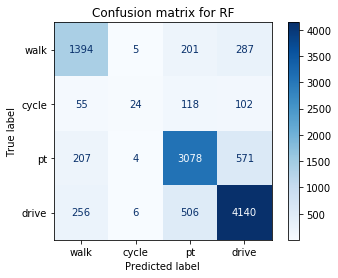

In [9]:
print('Confusion matrix, without normalization:')
display(confusion_matrix(y_validate, y_pred))

fig, ax = plt.subplots()
plot_confusion_matrix(rf, X_validate, y_validate, display_labels= classes, values_format= 'd', cmap=plt.cm.Blues, ax = ax)
ax.set_title('Confusion matrix for RF')
plt.show()

# Question 4
We now use the function `predict_proba` to compute the log loss. In addition, we can have a look at the predicted probabilities.

In [10]:
pred_proba = rf.predict_proba(X_validate)

In [11]:
pred_proba

array([[0. , 0. , 0.7, 0.3],
       [0.1, 0. , 0.1, 0.8],
       [0. , 0. , 0.6, 0.4],
       ...,
       [0. , 0. , 0.2, 0.8],
       [0.1, 0. , 0. , 0.9],
       [0. , 0. , 0. , 1. ]])

In the case of the RF, we're using `max_depth` equals to `None` and the number of estimators to 10. So, what is happening is that instead of giving a real probability, it's using the ratio of one-to-one mode, *i.e.* each data point is linked to a leaf in each tree due to no max depth. Then, we calculate the ratio each time a data point was associated to a label, and *Tada!*. 

We can now show the value of the log loss:

In [12]:
log_loss(y_validate, pred_proba)

1.341127953547987

# Question 5

We need to have a look at the parameters `n_estimators` and `max_depth`. In addition, we're interested in the time it takes to fit the model. So, we can use the python library `time` to capture it.

Let's first prepare the values we want to test.

In [13]:
max_depth = [None, 100, 50, 20, 10, 5, 2, 1]

n_estimators = [1000, 500, 200, 100, 10, 5, 2, 1]

In [14]:
# Matrices for the time and the log loss
times = np.zeros((len(max_depth), len(n_estimators)))
ll = np.zeros((len(max_depth), len(n_estimators)))

for i, d in enumerate(max_depth):
    for j, est in enumerate(n_estimators):
        
        print("max_depth = {}; n_estimators = {}".format(d, est))
        
        rf = RandomForestClassifier(criterion='entropy',
                                    n_estimators=est,
                                    max_depth=d,
                                    n_jobs=-1)
        
        start = time.time()
        rf.fit(X_train, y_train)
        stop = time.time()
        
        # Store the times
        times[i,j] = stop-start
        
        pred_proba = rf.predict_proba(X_validate)
        
        # Store the log loss
        ll[i,j] = log_loss(y_validate, pred_proba)
        
        

max_depth = None; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = None; n_estimators = 1


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 100; n_estimators = 1


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 50; n_estimators = 1


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 20; n_estimators = 1


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 10; n_estimators = 1
max_depth = 5; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 5; n_estimators = 1
max_depth = 2; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 2; n_estimators = 1
max_depth = 1; n_estimators = 1000


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()
/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 500


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 200


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 100


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 10


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 5


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 2


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


max_depth = 1; n_estimators = 1


/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


Let's find the best set of parameters and print it.

In [15]:
(best_depth_idx, best_estim_idx) = np.unravel_index(ll.argmin(), ll.shape)

In [16]:
best_depth = max_depth[best_depth_idx]
best_estim = n_estimators[best_estim_idx]

print("Best LL = {:.3f}. Parameters: (max_depth = {}, n_estimators = {})".format(ll.min(), best_depth, best_estim))

Best LL = 0.514. Parameters: (max_depth = None, n_estimators = 1000)


We can have a better look at the combination of these parameters. We plot the log10 of the values because the log loss range between 0.5 and 10. We can see that the best log losses are in the upper left corner with high values for both the number of estimators and the depth.

Text(0, 0.5, '# estimators')

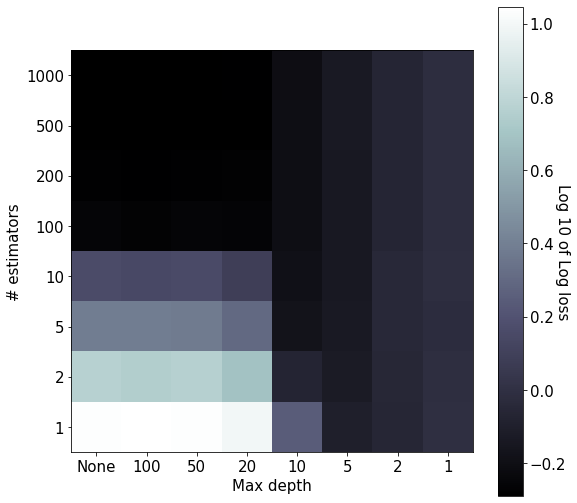

In [17]:
# Bigger font size
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log10(ll).T, cmap='bone')
cbar = fig.colorbar(cax)

cbar.ax.set_ylabel('Log 10 of Log loss', rotation=270)

plt.xticks(range(len(max_depth)), ['None'] + max_depth[1:])
plt.xlabel('Max depth')
ax.xaxis.set_ticks_position('bottom')

plt.yticks(range(len(n_estimators)), n_estimators)
plt.ylabel('# estimators')

If we have a look at the time it took to fit, we see that the best parameters often took the most time to train. It was expected since we're using more trees with more depth.

Text(0, 0.5, '# estimators')

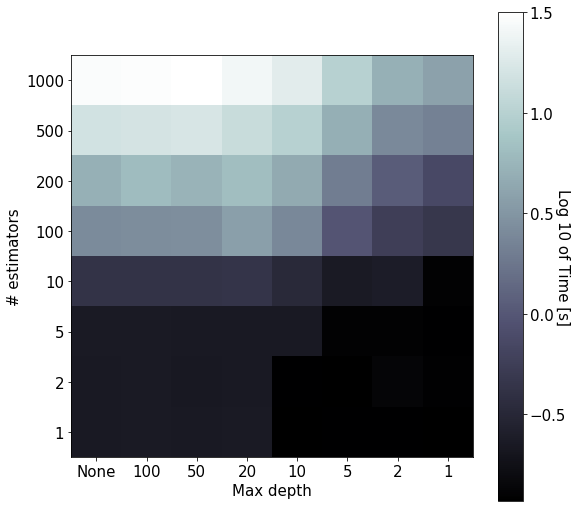

In [18]:
# Bigger font size
matplotlib.rcParams.update({'font.size': 15})

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log10(times).T, cmap='bone')
cbar = fig.colorbar(cax)

cbar.ax.set_ylabel('Log 10 of Time [s]', rotation=270)

plt.xticks(range(len(max_depth)), ['None'] + max_depth[1:])
plt.xlabel('Max depth')
ax.xaxis.set_ticks_position('bottom')

plt.yticks(range(len(n_estimators)), n_estimators)
plt.ylabel('# estimators')

# Question 6
Let's now extract the feature importance from the RF. The way to do it is given here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

But first, we have to refit our model with the best parameters.

In [19]:
rf = RandomForestClassifier(criterion='entropy',
                            n_estimators=best_estim,
                            max_depth=best_depth,
                            n_jobs=-1)

rf.fit(X_train, y_train)

/Users/janodypougala/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

We won't use the code exactly as it is given in the link above. Indeed, we want to display the name of the features.

In [20]:
names = X_train.columns.values

In [21]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("{}. {} ({:.3f})".format(f + 1, names[indices[f]], importances[indices[f]]))

Feature ranking:
1. distance (0.081)
2. dur_walking (0.074)
3. car_ownership (0.066)
4. dur_cycling (0.065)
5. driving_traffic_percent (0.059)
6. dur_driving (0.056)
7. dur_pt_total (0.051)
8. cost_driving_fuel (0.050)
9. cost_driving_total (0.048)
10. age (0.042)
11. dur_pt_access (0.041)
12. dur_pt_bus (0.039)
13. fueltype:Average_Car (0.037)
14. start_time_linear (0.036)
15. travel_date (0.033)
16. travel_month (0.027)
17. day_of_week (0.024)
18. driving_license (0.023)
19. dur_pt_rail (0.019)
20. cost_transit (0.013)
21. dur_pt_int_waiting (0.010)
22. fueltype:Petrol_Car (0.010)
23. cost_driving_con_charge (0.010)
24. dur_pt_int_total (0.009)
25. female (0.008)
26. purpose:HBO (0.008)
27. purpose:HBW (0.007)
28. dur_pt_int_walking (0.006)
29. bus_scale (0.006)
30. faretype:free (0.006)
31. fueltype:Diesel_Car (0.006)
32. faretype:full (0.005)
33. pt_n_interchanges (0.005)
34. purpose:HBE (0.005)
35. purpose:NHBO (0.004)
36. purpose:B (0.003)
37. faretype:dis (0.002)
38. faretype:ch

Text(0, 0.5, 'Feature importance')

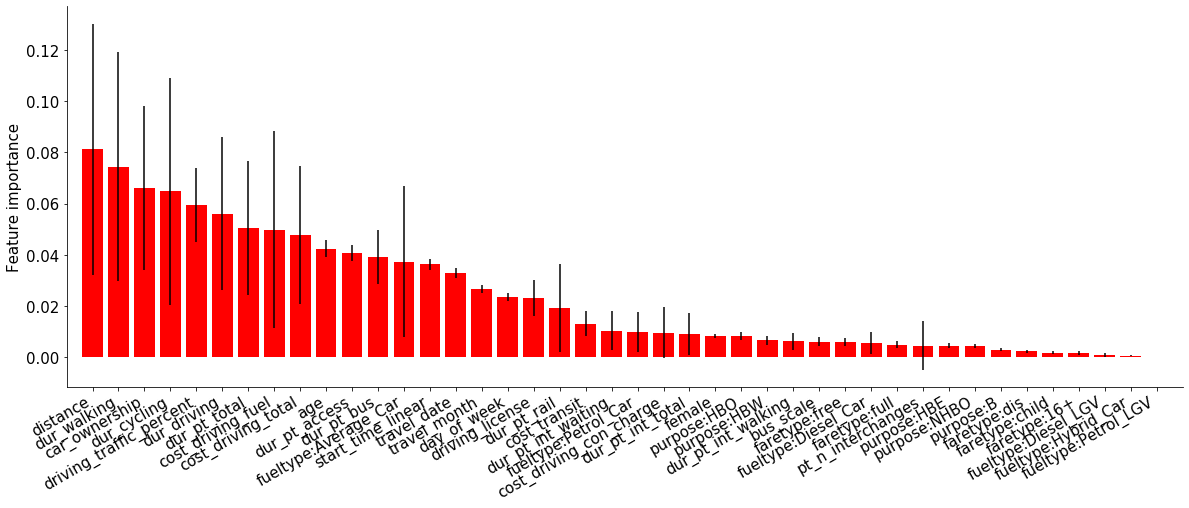

In [22]:
# Plot the feature importances of the forest

plt.figure(figsize=(20, 7), frameon=False)

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), names[indices])
plt.xlim([-1, X.shape[1]])

for label in ax.get_xmajorticklabels():
    label.set_rotation(30)
    label.set_horizontalalignment("right")
    
plt.ylabel('Feature importance')
